# **Lab 7: Optimization and learning**
**Christoffer Ejemyr**

# **Abstract**

The purpose of this report is to implement methods to find stationary points of functions. _Gradient decent_ and _Newton minimization method_ were used. Both methods were tested for three different funcitons and converged in all cases. The Newtons method generally converged quicker and 

# **About the code**

In [1]:
"""This program is a lab report in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Christoffer Ejemyr (ejemyr@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

'KTH Royal Institute of Technology, Stockholm, Sweden.'

Problems discussed with Leo Enge.

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [7]:
# Load neccessary modules.

import time
import numpy as np

%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import newton
from scipy.linalg import expm

from typing import Callable, Union

# **Introduction**

In this lab we aim to implement two algorithms to find a local minimum/maximum of a function $f: R^n \rightarrow R$ for an arbitrary $n$. The algorithms are _Gradient decent_ and _Newton minimization_. Finding the minimum/maximum of a function has many applications in optimization, which in turn can be useful in a variety of feilds.

# **Methods**

### Gradient
We implement the gradient, $\nabla f(x) = \left(\frac{\partial f}{\partial x_1}, \ldots, \frac{\partial f}{\partial x_n} \right)$, by letting $\frac{\partial f}{\partial x_i} = \frac{f(x + dx_i) - f(x - dx_i)}{2dx}$ where $dx_i$ is the vector with $dx$ at index $i$ and zeros elsewhere.

### Hessian
The hessian in some manner represent the second derivative of a general function. It is implemented forward derivative for simplicity.

### Line-search
The search finds the value for $\alpha = 10^(-i), i \in {1, 2, 3, 4, 5}$ where $f(x - \alpha \nabla f(x))$ is as small as posible.

### Gradient decent
This is implementet using method 15.1 in the lecture notes and the gradient explanied above. Also a maximum number of itterations is used.

### Newton minimization
This is implementet using method 15.3 in the lecture notes and the gradient and hessian explanied above. Also a maximum number of itterations is used.

In [44]:
def grad(f, x, dx=1e-3):
    return np.array([(f(x + dx_i) - f(x - dx_i)) / (2 * dx) for dx_i in np.diag(np.full(x.size, dx))])

def hessian(f, x, grad_f_x, dx=1e-3):
    return np.array([(grad(f, x + h) - grad_f_x) / dx for h in np.diag(np.full(x.size, dx))])

def get_minima_on_line(f, grad_f_x0, x):
    return np.power(10., -np.argmin([f(x - np.power(10., -i) * grad_f_x0) for i in range(1, 6)]) - 1)

def gradient_descent_method(f, x0, TOL=1e-6, maxitter=100):
    x = [x0]
    val = [f(x0)]
    grad_f_x = grad(f, x[-1])
    i = 0
    while (maxitter is None) or (i < maxitter):
        x.append(x[-1] - get_minima_on_line(f, grad_f_x, x[-1]) * grad_f_x)
        val.append(f(x[-1]))
        grad_f_x = grad(f, x[-1])
        if np.linalg.norm(grad_f_x) <= TOL:
            print("Minima found! Norm of gradient was", np.linalg.norm(grad_f_x), "and x is given by", x[-1])
            break
        i += 1
    else:
        print("Minima not found within specified number of itterations.")
        return None, x, val
    
    return x[-1], x, val

def newton_minimization(f, x0, TOL=1e-6, maxitter=100):
    x = [x0]
    val = [f(x0)]
    grad_f_x = grad(f, x[-1])
    hess_f_x = hessian(f, x[-1], grad_f_x)
    i = 0
    while (maxitter is None) or (i < maxitter):
        try:
            if len(x0) == 1:
                x.append(x[-1] - np.linalg.solve(hess_f_x, grad_f_x)[0])
            else:
                x.append(x[-1] - np.linalg.solve(hess_f_x, grad_f_x))
        except:
            break
        val.append(f(x[-1]))
        grad_f_x = grad(f, x[-1])
        hess_f_x = hessian(f, x[-1], grad_f_x)
        if np.linalg.norm(grad_f_x) <= TOL:
            print("Minima found! Norm of gradient was", np.linalg.norm(grad_f_x), "and x is given by", x[-1])
            return x[-1], x, val
        i += 1
    else:
        print("Minima not found within specified number of itterations.")
        return None, x, val
    
    print("Hessian became singular, which we treat as found! Norm of gradient was", np.linalg.norm(grad_f_x), "and x is given by", x[-1])
    return x[-1], x, val

# **Results**

To test the methods we use som intresing functions and investigate wether the methods converge to a minima/maxima. For resons of visualization we only use functions $f: R \rightarrow R$ and $f: R^2 \rightarrow R$.

The norm of the input vector/value is plotted as well as the value on the path. This shows posible convergense of the respective values.

In [45]:
def plot_function_from_f(f, f_name, x_dim, size_min=10):
    num_of_points = 100
    linspace = np.linspace(size_min, -size_min, num_of_points)
    
    X, Y, Z, fig, ax = None, None, None, None, None
    if x_dim == 1 or x_dim == 2:
        fig = plt.figure()
    if x_dim == 1:
        X = linspace
        Y = np.array([f(x) for x in X])
        ax = plt.axes()
        ax.plot(X, Y)
        ax.set_ylabel('f(x)')
    elif x_dim == 2:
        X, Y = np.meshgrid(linspace, linspace)
        Z = np.array([[f([x, y]) for x in linspace] for y in linspace])
        ax = plt.axes(projection='3d')
        ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.3)
        ax.set_ylabel('y')
        ax.set_zlabel('f(x)')
        
    if x_dim == 1 or x_dim == 2:
        ax.set_title(f_name)
        ax.set_xlabel('x')
        plt.show()
        
    return fig

def plot_path_on_surface(method_name, path, fig):
    plt.figure(fig.number)
    ax = None
    if len(path[:, 0]) == 2:
        ax = plt.gca()
        ax.plot(path[0], path[1], label=method_name)
        ax.scatter(path[0][0], path[1][0], color='g')
        ax.scatter(path[0][-1], path[1][-1], color='r')
    elif len(path[:, 0]) == 3:
        ax = plt.gca(projection='3d')
        ax.plot(path[0], path[1], path[2], label=method_name)
        ax.scatter(path[0][0], path[1][0], path[2][0], color='g')
        ax.scatter(path[0][-1], path[1][-1], path[2][-1], color='r')
    if ax is not None:
        ax.legend()
    plt.show()
    
def plot_convergence(method_name, path, fig):
    x = None
    if len(path[:, 0]) == 2:
        x = [abs(path[:-1, i]) for i in range(len(path[0, :]))]
    elif len(path[:, 0]) == 3:
        x = np.linalg.norm(path[:-1, :], axis=0)
    
    plt.figure(fig.number)
    axes = fig.get_axes()
    ax1, ax2 = None, None
    if len(axes) == 0:
        ax1, ax2 = fig.subplots(nrows=2, ncols=1, sharex=True)
    else:
        ax1, ax2 = axes
    ax2.set_xlabel("Step")
    ax1.set_title("Norm of x")
    ax2.set_title("Function value")
    ax1.set_ylabel(r"$||x||$")
    ax2.set_ylabel(r"$f(x)$")
    
    ax1.plot(np.arange(len(x)), x, '-o', label=method_name)
    ax2.plot(np.arange(len(path[-1, :])), path[-1, :], '-o', label=method_name)
    ax1.legend()
    ax2.legend()
    plt.show()
    

In [46]:
def test_function(f, f_name, x0):
    function_fig = plot_function_from_f(f, f_name, len(x0), 7.5)
    convergence_fig = plt.figure()
    for (x_min, path_x, path_val), method_name in zip([gradient_descent_method(f, x0), newton_minimization(f, x0)], ["Grad decent", "Newton min"]):
        path = np.array([[*x, f] for x, f in zip(path_x, path_val)]).T
        plot_path_on_surface(method_name, path, function_fig)
        plot_convergence(method_name, path, convergence_fig)

<IPython.core.display.Javascript object>


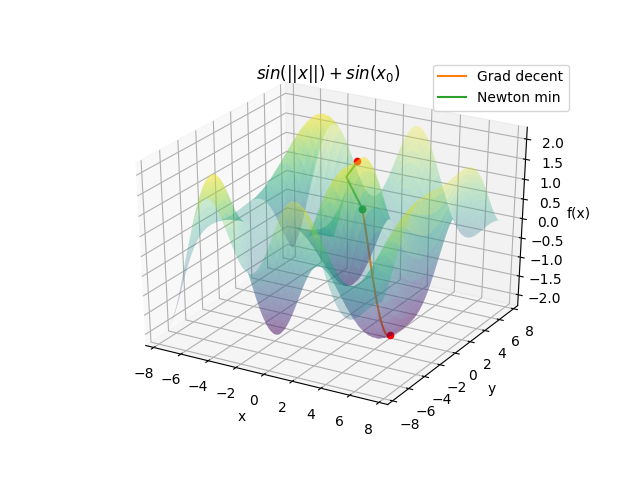

<IPython.core.display.Javascript object>


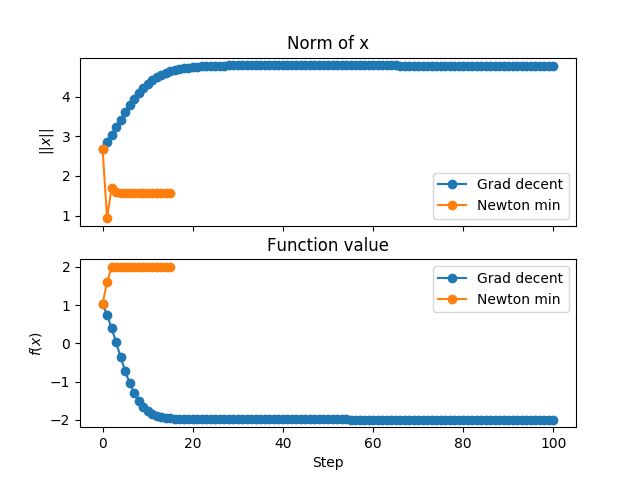

Minima not found within specified number of itterations.
Minima found! Norm of gradient was 8.740395393937189e-07 and x is given by [ 1.57079652e+00 -1.24987264e-03]


<IPython.core.display.Javascript object>


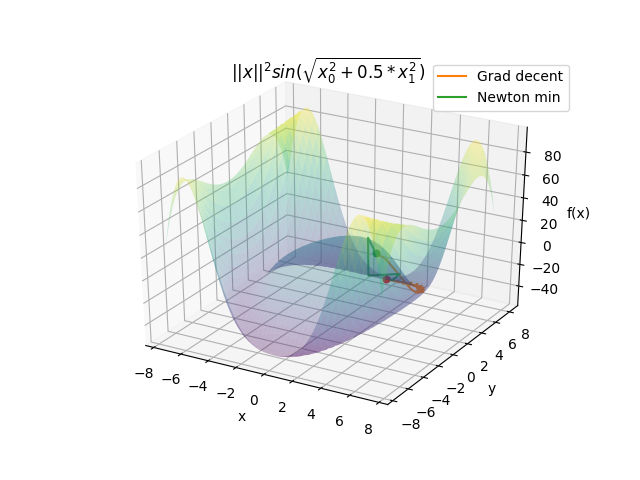

<IPython.core.display.Javascript object>


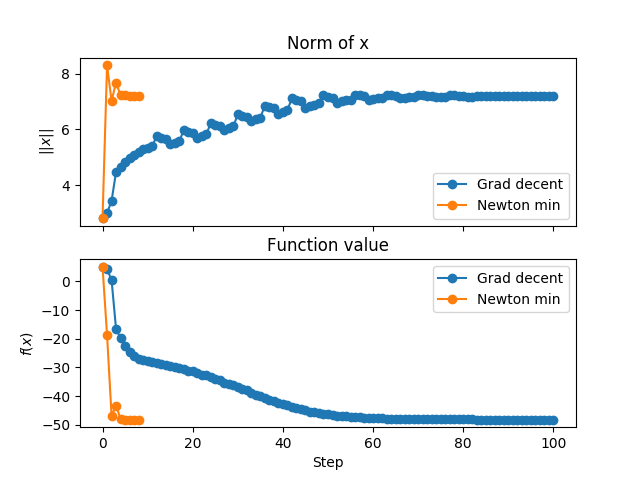

Minima not found within specified number of itterations.
Minima found! Norm of gradient was 3.7003889607780755e-08 and x is given by [9.13351722e-09 7.19408323e+00]


<IPython.core.display.Javascript object>


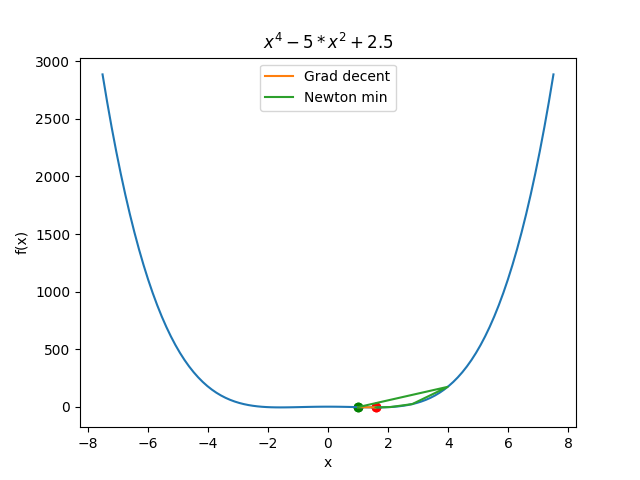

<IPython.core.display.Javascript object>


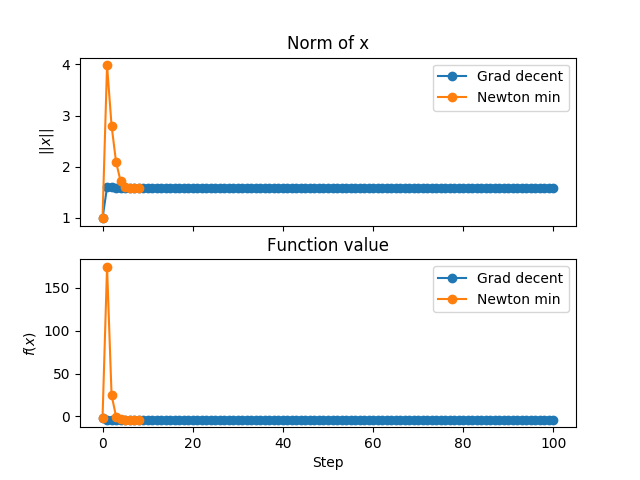

Minima not found within specified number of itterations.
Minima found! Norm of gradient was 5.444089623551918e-09 and x is given by [1.58113851]


In [47]:
name_list = []
f_list = []
x0_list = []

name_list.append(r"$sin(||x||) + sin(x_0)$")
f_list.append(lambda x: np.sin(np.linalg.norm(x)) + np.sin(x[0]))
x0_list.append(np.array([2.5, -1]))

name_list.append(r"$||x||^2 sin(\sqrt{x_0^2 + 0.5 * x_1^2})$")
f_list.append(lambda x: np.linalg.norm(x)**2 * np.sin(np.sqrt(x[0]**2 + 0.5 * x[1]**2)))
x0_list.append(np.array([2, 2]))

name_list.append(r"$x^4 - 5 * x^2 + 2.5$")
f_list.append(lambda x: x**4 - 5 * x**2 + 2.5)
x0_list.append(np.array([1]))

for f, f_name, x0 in zip(f_list, name_list, x0_list):
    test_function(f, f_name, x0)

# Discussion

Both methods converge in all cases, but generally the Newton method converges faster. I the fist case the mathods converge to different points since the newton method can find any minima/maxima while the gradient decent only finds local minima och sadel points. It is also intresting to note that the gradient decent often converges quickly, but often never acctually gets inside the tolerance.